In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [2]:
from data_analysis_helper_fun import normalized_heat_maps_by_weights

## Loading data

In [4]:
# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [ ]:
# relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha'
data_file_name = f'{data_set_name}.csv' #.tar.gz'

In [3]:
re_data = load_re_data(data_dir, 
                                data_file_name,
                                usecols = ["model_name",
                                           'n_sentence_pool',
                                           "ds",
                                           "init_coms",
                                           "init_coms_dia_consistent",
                                           'weight_account', 
                                           'weight_systematicity',
                                           "go_coms_consistent",
                                           "fp_coms_consistent",
                                           "fixed_point_coms_consistent",
                                           "fixed_point_dia_consistent",
                                           "n_fixed_points",
                                           "n_global_optima",
                                           "go_union_consistent",
                                           "fp_union_consistent",
                                           "error_code"
                                           ],
                               evalcols = [
                                    'go_coms_consistent',
                                    'fp_coms_consistent',
                                    "go_union_consistent",
                                    "fp_union_consistent"
                                   ],
                      filter_erroneous_runs = True)

In [5]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 4136547
   Number of dialectical structures: 200
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [6]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'init_coms_dia_consistent',
       'fixed_point_coms_consistent', 'fixed_point_dia_consistent',
       'error_code', 'n_fixed_points', 'fp_coms_consistent',
       'fp_union_consistent', 'n_global_optima', 'go_coms_consistent',
       'go_union_consistent', 'model_short_name'],
      dtype='object')

## Setup dataframes

In [62]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point  
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setup.
"""
analyse_branches = True



# control the grouping of the dataframe during aggregation 
grouping = ['model_name',
            #'ds',
            #'init_coms',
            #'weight_account',
            #'weight_systematicity'
           ]

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = True

In [63]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         #"n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         #'weight_faithfulness', 
                         'init_coms'
                        ])

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity", 
                                 "init_coms_dia_consistent", 
                                 "go_coms_consistent",
                                 "go_union_consistent"]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_coms_consistent`) 
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity", 
                                      "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(2845799, 8)

In [64]:
re_data_unique_setups.groupby("model_name")["ds"].size()

model_name
LinearGlobalRE       143973
LinearLocalRE        142219
QuadraticGlobalRE    143964
QuadraticLocalRE     143079
Name: ds, dtype: int64

In [65]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       "init_coms_dia_consistent", 
                       "fixed_point_coms_consistent",
                       "fixed_point_dia_consistent"]]
    
    # rename fixed point columns 
    # note: data is already exploded
    exploded_fp_data = fp_data.rename(columns={"fixed_point_coms_consistent": "fp_coms_consistent",
                                               "fixed_point_dia_consistent": "fp_union_consistent"})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "init_coms_dia_consistent", 
                                     "fp_coms_consistent",
                                     "fp_union_consistent"]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `go_coms_consistent`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity", 
                                          "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(4136547, 8)

In [66]:
# quick check: If `analyse_branches` is false, the length of exploed_fp_data 
# should be equal to the number of unique fixed points in the dataframe with unique setups
re_data_unique_setups["n_fixed_points"].sum()

1587288

In [67]:
# quick check: number of unique setups. 
# Differences between model variants may arise from filtering out erroneous runs
go_data.groupby("model_name")["go_union_consistent"].size()

model_name
LinearGlobalRE       143973
LinearLocalRE        142219
QuadraticGlobalRE    143964
QuadraticLocalRE     143079
Name: go_union_consistent, dtype: int64

## Consistency I: Output
Are the outputs of RE simulations dialectically consistent?

In [68]:
grouped_go_data = exploded_go_data.groupby(grouping)["go_coms_consistent"].agg(["sum", "size"]).reset_index()


grouped_go_data = grouped_go_data.rename(columns={'sum': "n_go_coms_consistent",
                                                  'size': 'n_global_optima'})

# relative shares
grouped_go_data["rel_go_coms_consistent"] = grouped_go_data["n_go_coms_consistent"]/grouped_go_data["n_global_optima"]

grouped_go_data

,model_name,n_go_coms_consistent,n_global_optima,rel_go_coms_consistent
0,LinearGlobalRE,540556,700830,0.771308
1,LinearLocalRE,554525,721096,0.769003
2,QuadraticGlobalRE,529359,714584,0.740793
3,QuadraticLocalRE,525490,709289,0.740869


In [69]:
grouped_fp_data = exploded_fp_data.groupby(grouping)["fp_coms_consistent"].agg(["sum", "size"]).reset_index()


grouped_fp_data = grouped_fp_data.rename(columns={'sum': "n_fp_coms_consistent",
                                                  'size': 'n_fixed_points'})

# relative shares
grouped_fp_data["rel_fp_coms_consistent"] = grouped_fp_data["n_fp_coms_consistent"]/grouped_fp_data["n_fixed_points"]

grouped_fp_data

,model_name,n_fp_coms_consistent,n_fixed_points,rel_fp_coms_consistent
0,LinearGlobalRE,227097,313002,0.725545
1,LinearLocalRE,1240692,1303077,0.952125
2,QuadraticGlobalRE,374476,528616,0.708408
3,QuadraticLocalRE,1463131,1991852,0.734558


In [70]:
# separate tables for go and fp

for df, endpoint_type in zip([grouped_go_data, grouped_fp_data], ["go", "fp"]):
    
    # sort by model name
    df['model_name'] = pd.Categorical(df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
    df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   'n_go_coms_consistent': 'Number of global optima with consistent commitments',
                   'n_global_optima': 'Number of global optima',
                   'rel_go_coms_consistent': 'Relative share of global optima with consistent commitments',
                   'n_fp_coms_consistent': 'Number of fixed points with consistent commitments',
                   'n_fixed_points': 'Number of fixed points',
                   'rel_fp_coms_consistent': 'Relative share of fixed points with consistent commitments',
                  }

    display(df.rename(columns=cols_for_tables))
    
    
    if export_results:
        file_name = 'table_consistency_outputs_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Number of global optima with consistent commitments,Number of global optima,Relative share of global optima with consistent commitments
2,QuadraticGlobalRE,529359,714584,0.740793
0,LinearGlobalRE,540556,700830,0.771308
3,QuadraticLocalRE,525490,709289,0.740869
1,LinearLocalRE,554525,721096,0.769003


,Model,Number of fixed points with consistent commitments,Number of fixed points,Relative share of fixed points with consistent commitments
2,QuadraticGlobalRE,374476,528616,0.708408
0,LinearGlobalRE,227097,313002,0.725545
3,QuadraticLocalRE,1463131,1991852,0.734558
1,LinearLocalRE,1240692,1303077,0.952125


### Heatmaps

In [71]:
new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [72]:
wgrouped_go_data = exploded_go_data.groupby(new_grouping)["go_coms_consistent"].agg(["sum", "size"]).reset_index()


wgrouped_go_data = wgrouped_go_data.rename(columns={'sum': "n_go_coms_consistent",
                                                  'size': 'n_global_optima'})

wgrouped_go_data["rel_go_coms_consistent"] = wgrouped_go_data["n_go_coms_consistent"]/wgrouped_go_data["n_global_optima"]

# sort by model name
wgrouped_go_data['model_name'] = pd.Categorical(wgrouped_go_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
wgrouped_go_data.sort_values("model_name", inplace=True)

#wgrouped_go_data

In [73]:
wgrouped_fp_data = exploded_fp_data.groupby(new_grouping)["fp_coms_consistent"].agg(["sum", "size"]).reset_index()


wgrouped_fp_data = wgrouped_fp_data.rename(columns={'sum': "n_fp_coms_consistent",
                                                  'size': 'n_fixed_points'})

wgrouped_fp_data["rel_fp_coms_consistent"] = wgrouped_fp_data["n_fp_coms_consistent"]/wgrouped_fp_data["n_fixed_points"]

# sort by model name
wgrouped_fp_data['model_name'] = pd.Categorical(wgrouped_fp_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
wgrouped_fp_data.sort_values("model_name", inplace=True)

#wgrouped_fp_data

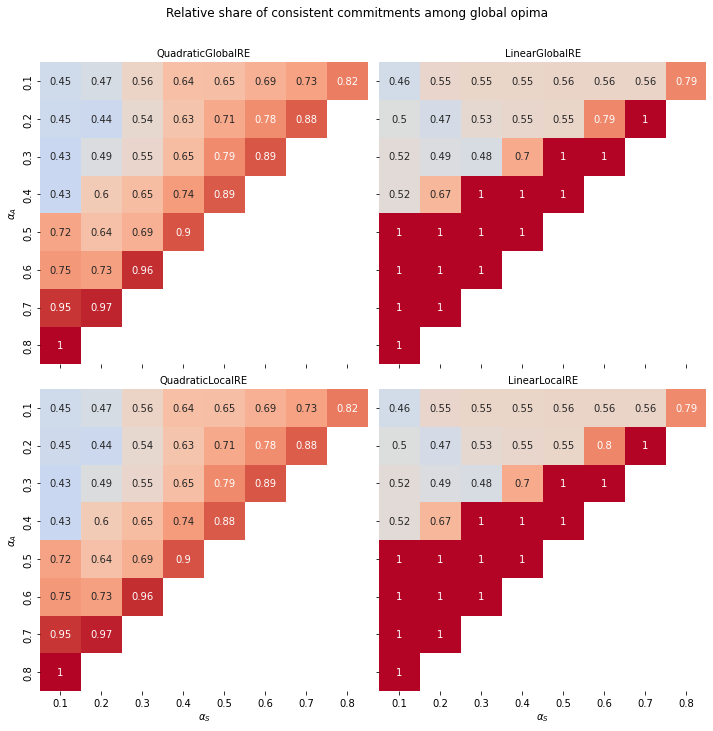

<Figure size 432x288 with 0 Axes>

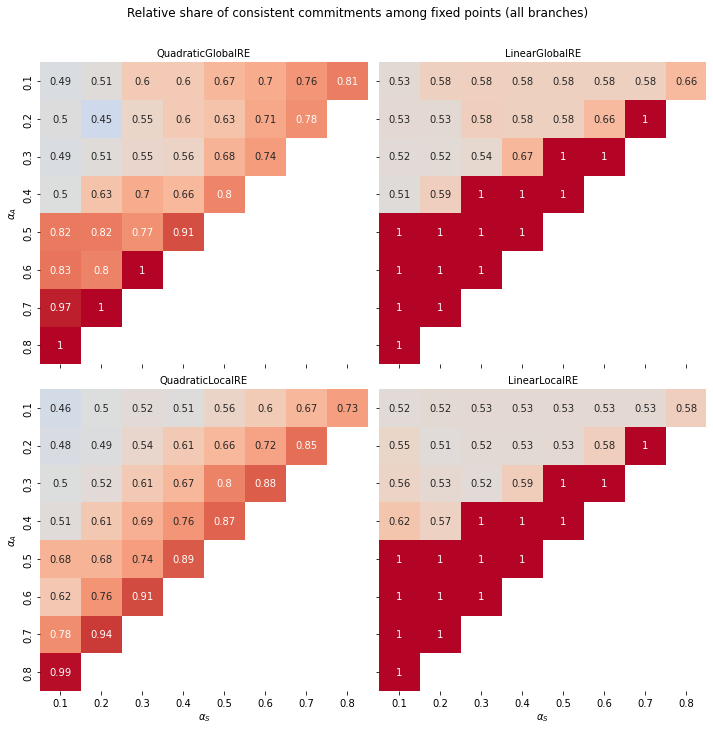

<Figure size 432x288 with 0 Axes>

In [74]:
for df, endpoint_type in zip([wgrouped_go_data, wgrouped_fp_data], ["go", "fp"]):

    endpoint = "global opima" if endpoint_type == "go" else "fixed points"
    
    if (analyse_branches) & (endpoint_type=="fp"):
        endpoint += " (all branches)"
    
    normalized_heat_maps_by_weights(re_data = df, 
                     values = "rel_{}_coms_consistent".format(endpoint_type), 
                     title = 'Relative share of consistent commitments among {}'.format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.1f}')
    plt.show()
    
    branches = "branches" if analyse_branches else "setups"
        
    if export_results:
        plt.savefig(path.join(figures_output_dir, 'weight_consistency_outputs_{}_{}.png'.format(endpoint_type, branches)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'weight_consistency_outputs_{}_{}.pdf'.format(endpoint_type, branches)), bbox_inches='tight')

## Consistency II:  Input-Output
Does the consistency status change between corresponding inputs and outputs of RE simulations?

### Labelling cases

In [75]:
# conversion to type bool
exploded_go_data['init_coms_dia_consistent'] = exploded_go_data['init_coms_dia_consistent'].astype('bool')
exploded_go_data['go_coms_consistent'] = exploded_go_data['go_coms_consistent'].astype('bool')

In [76]:
# global optima
exploded_go_data['go_inconsistency_eliminating_case'] = (~exploded_go_data['init_coms_dia_consistent']) & exploded_go_data['go_coms_consistent']
exploded_go_data['go_consistency_preserving_case'] = exploded_go_data['init_coms_dia_consistent'] & exploded_go_data['go_coms_consistent']
exploded_go_data['go_inconsistency_preserving_case'] = (~exploded_go_data['init_coms_dia_consistent']) & (~exploded_go_data['go_coms_consistent'])
exploded_go_data['go_consistency_eliminating_case'] = (exploded_go_data['init_coms_dia_consistent']) & (~exploded_go_data['go_coms_consistent'])

In [77]:
display(exploded_go_data.head(6)[[#'global_optima',
                                  'init_coms_dia_consistent',
                                  'go_coms_consistent', 
                                  'go_inconsistency_eliminating_case',
                                  'go_consistency_preserving_case',
                                  'go_inconsistency_preserving_case',
                                  'go_consistency_eliminating_case'
                                 ]])

,init_coms_dia_consistent,go_coms_consistent,go_inconsistency_eliminating_case,go_consistency_preserving_case,go_inconsistency_preserving_case,go_consistency_eliminating_case
0,True,False,False,False,False,True
1,True,True,False,True,False,False
2,True,True,False,True,False,False
3,True,True,False,True,False,False
4,True,True,False,True,False,False
5,True,True,False,True,False,False


In [78]:
# conversion to type bool
exploded_fp_data['init_coms_dia_consistent'] = exploded_fp_data['init_coms_dia_consistent'].astype('bool')
exploded_fp_data['fp_coms_consistent'] = exploded_fp_data['fp_coms_consistent'].astype('bool')

In [79]:
# fixed points
exploded_fp_data['fp_inconsistency_eliminating_case'] = ~(exploded_fp_data['init_coms_dia_consistent']) & exploded_fp_data['fp_coms_consistent']
exploded_fp_data['fp_consistency_preserving_case'] = exploded_fp_data['init_coms_dia_consistent'] & exploded_fp_data['fp_coms_consistent']
exploded_fp_data['fp_inconsistency_preserving_case'] = ~(exploded_fp_data['init_coms_dia_consistent']) & ~(exploded_fp_data['fp_coms_consistent'])
exploded_fp_data['fp_consistency_eliminating_case'] = exploded_fp_data['init_coms_dia_consistent'] & ~(exploded_fp_data['fp_coms_consistent'])

In [80]:
display(exploded_fp_data.head(6)[[#'fixed_point', 
                                  'fp_coms_consistent', 
                                  'fp_inconsistency_eliminating_case',
                                  'fp_consistency_preserving_case',
                                  'fp_inconsistency_preserving_case',
                                  'fp_consistency_eliminating_case'
                                 ]])

,fp_coms_consistent,fp_inconsistency_eliminating_case,fp_consistency_preserving_case,fp_inconsistency_preserving_case,fp_consistency_eliminating_case
0,False,False,False,False,True
1,True,False,True,False,False
2,True,False,True,False,False
3,True,False,True,False,False
4,True,False,True,False,False
5,True,False,True,False,False


In [81]:
# count cases in a group
go_result_df = exploded_go_data[['model_name',
                                 "ds",
                                 "init_coms",
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'go_coms_consistent', 
                                 'go_inconsistency_eliminating_case',
                                 'go_consistency_preserving_case',
                                 'go_inconsistency_preserving_case',
                                 'go_consistency_eliminating_case']].groupby(grouping).agg('sum').reset_index()

# count total number of global optima in a group
go_result_df['n_global_optima'] = go_result_df.apply(lambda x: sum(x[col] for col in ['go_inconsistency_eliminating_case',
                                 'go_consistency_preserving_case',
                                 'go_inconsistency_preserving_case',
                                 'go_consistency_eliminating_case']) , axis=1)

#go_result_df.reset_index(inplace=True)

In [82]:
go_result_df.shape

(4, 9)

In [83]:
go_result_df["n_global_optima"].sum()

2845799

In [84]:
re_data_unique_setups["n_global_optima"].sum()

2845799

In [85]:
# count cases in a group
fp_result_df = exploded_fp_data[['model_name',
                                 'ds',
                                 'init_coms',
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'fp_coms_consistent', 
                                 'fp_inconsistency_eliminating_case',
                                 'fp_consistency_preserving_case',
                                 'fp_inconsistency_preserving_case',
                                 'fp_consistency_eliminating_case']].groupby(grouping).agg('sum').reset_index()

# count total number of fixe points in a group
fp_result_df['n_fixed_points'] = fp_result_df.apply(lambda x: sum(x[col] for col in ['fp_inconsistency_eliminating_case',
                                 'fp_consistency_preserving_case',
                                 'fp_inconsistency_preserving_case',
                                 'fp_consistency_eliminating_case']) , axis=1)

#fp_result_df.reset_index(inplace=True)

In [87]:
# quick check: number of fixed points
fp_result_df["n_fixed_points"].sum()

4136547

### Tables

In [88]:
# relative share of consistency cases

for df, endpoint_type in zip([fp_result_df, go_result_df], ['fp', 'go']):
    for case_name in ["inconsistency_eliminating", 
                      "consistency_preserving", 
                      "inconsistency_preserving", 
                      "consistency_eliminating"]:
        
        endpoint_name = "n_global_optima" if endpoint_type == "go" else "n_fixed_points"
    
        relative_share_col_name = 'rel_' + endpoint_type + '_' + case_name + '_case' 
        
        df[relative_share_col_name] = df[endpoint_type + '_' + case_name + '_case']/df[endpoint_name]

In [89]:
# group by model name and calculate average (depending on grouping, this may be superfluous)

fp_overall_results = fp_result_df.groupby(['model_name',
                     #'ds',
                     #'init_coms',
                     #'weight_account',
                     #'weight_systematicity'
                     ])[["rel_fp_inconsistency_eliminating_case",
                         "rel_fp_consistency_preserving_case",
                         "rel_fp_inconsistency_preserving_case",
                         "rel_fp_consistency_eliminating_case"]].mean().reset_index()


go_overall_results = go_result_df.groupby(['model_name',
                     #'ds',
                     #'init_coms',
                     #'weight_account',
                     #'weight_systematicity'
                     ])[["rel_go_inconsistency_eliminating_case",
                         "rel_go_consistency_preserving_case",
                         "rel_go_inconsistency_preserving_case",
                         "rel_go_consistency_eliminating_case"]].mean().reset_index()

In [91]:
# separate tables for go and fp

for df, endpoint_type in zip([go_overall_results, fp_overall_results], ["go", "fp"]):
    
    # sort by model name
    df['model_name'] = pd.Categorical(df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
    df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   "rel_go_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases among global optima",
                   "rel_go_consistency_preserving_case": "Relative share of consistency preserving cases among global optima",
                   "rel_go_inconsistency_preserving_case": "Relative share of inconsistency preserving cases among global optima",
                   "rel_go_consistency_eliminating_case": "Relative share of consistency eliminating cases among global optima",
                   "rel_fp_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases among fixed points",
                   "rel_fp_consistency_preserving_case": "Relative share of consistency preserving cases among fixed points",
                   "rel_fp_inconsistency_preserving_case": "Relative share of inconsistency preserving cases among fixed points",
                   "rel_fp_consistency_eliminating_case": "Relative share of consistency eliminating cases among fixed points",
                  }

    display(df.rename(columns=cols_for_tables))
    
    
    # Exporting relevant cols
    if export_results:
        file_name = 'table_consistency_cases_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Relative share of inconsistency eliminating cases among global optima,Relative share of consistency preserving cases among global optima,Relative share of inconsistency preserving cases among global optima,Relative share of consistency eliminating cases among global optima
2,QuadraticGlobalRE,0.229184,0.511610,0.230459,0.028748
0,LinearGlobalRE,0.260928,0.510381,0.216412,0.012280
3,QuadraticLocalRE,0.226789,0.514080,0.230625,0.028506
1,LinearLocalRE,0.264676,0.504327,0.218940,0.012057


,Model,Relative share of inconsistency eliminating cases among fixed points,Relative share of consistency preserving cases among fixed points,Relative share of inconsistency preserving cases among fixed points,Relative share of consistency eliminating cases among fixed points
2,QuadraticGlobalRE,0.229267,0.479142,0.269840,0.021751
0,LinearGlobalRE,0.194293,0.531252,0.265692,0.008764
3,QuadraticLocalRE,0.300645,0.433913,0.239338,0.026104
1,LinearLocalRE,0.482567,0.469558,0.044899,0.002976


### Plots

In [92]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [93]:
# color palette
viridis = ["#472c7a", "#2c718e", "#29ae80", "#b0dd31"]
viridis_light = ["rgba(71, 44, 122, 0.5)", "rgba(44, 113, 142, 0.5)", "rgba(41, 174, 128, 0.5)", "rgba(176, 221, 49, 0.5)"]

#### Barplots

#### Overall barplots across configuration of weights

In [94]:
def barplot(data, endpoint_type):
    
    
    y_cols = ["rel_{}_inconsistency_eliminating_case".format(endpoint_type),
              "rel_{}_consistency_preserving_case".format(endpoint_type),
              "rel_{}_inconsistency_preserving_case".format(endpoint_type),
              "rel_{}_consistency_eliminating_case".format(endpoint_type)]
    
    fig3 = px.bar(data.round(3), 
                  x="model_name", 
                  y=y_cols, 
                  barmode="stack", 
                  text_auto=True)

    fig3.update_yaxes(range=[0.0, 1.0])
    fig3.update_traces(name="Consistency preserving (CP)", 
                       marker_color=viridis[2], 
                       selector=dict(name='rel_{}_consistency_preserving_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Inconsistency eliminating (IE)", 
                       marker_color=viridis[3],
                       selector=dict(name='rel_{}_inconsistency_eliminating_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Inconsistency preserving (IP)",
                       marker_color=viridis[1],
                       selector=dict(name='rel_{}_inconsistency_preserving_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Consistency eliminating (CE)",
                       marker_color=viridis[0], 
                       selector=dict(name="rel_{}_consistency_eliminating_case".format(endpoint_type)))

    fig3.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       width=860,
                       margin={"t":80}
                      )

    fig3.update_xaxes(title="Model variant", showticklabels=True, showgrid=False, linecolor= 'DarkGrey')
    fig3.update_yaxes(title="Relative share", ticks="outside", tickcolor="DarkGrey", showgrid=False, linecolor='DarkGrey', zeroline=True, zerolinecolor="DarkGrey",
                      zerolinewidth=1)
    fig3.update_layout(legend_title_text="")
    fig3.update_layout(legend={'traceorder':'reversed', 
                              "orientation":"v", "x":1.0, "y":1.025, "xanchor":"left"})
    fig3.update_layout(title_text="Relative share of consistency cases among {}".format("global optima" if endpoint_type=="go" else "fixed points"))
    fig3.update_traces(opacity=0.8)
    fig3.show()



    if export_results:
        file_name = 'overall_consistency_cases_{}_{}.png'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig3.write_image(path.join(figures_output_dir, file_name), scale=2)
        
        file_name = 'overall_consistency_cases_{}_{}.pdf'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig3.write_image(path.join(figures_output_dir, file_name), scale=2)

In [95]:
barplot(go_overall_results, "go")
barplot(fp_overall_results, "fp")

#### Heatmaps

In [96]:
new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [97]:
# fixed_points

# count cases in a group
fp_df = exploded_fp_data[['model_name',
                                 'ds',
                                 'init_coms',
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'fp_coms_consistent', 
                                 'fp_inconsistency_eliminating_case',
                                 'fp_consistency_preserving_case',
                                 'fp_inconsistency_preserving_case',
                                 'fp_consistency_eliminating_case']].groupby(new_grouping).agg('sum').reset_index()

# count total number of fixed points in a group
fp_df['n_fixed_points'] = fp_df.apply(lambda x: sum(x[col] for col in ['fp_inconsistency_eliminating_case',
                                 'fp_consistency_preserving_case',
                                 'fp_inconsistency_preserving_case',
                                 'fp_consistency_eliminating_case']) , axis=1)


# sort by model name
fp_df['model_name'] = pd.Categorical(fp_df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
fp_df.sort_values("model_name", inplace=True)

In [98]:
fp_df['n_fixed_points'].sum()

4136547

In [99]:
# global optima

# count cases in a group
go_df = exploded_go_data[['model_name',
                                 "ds",
                                 "init_coms",
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'go_coms_consistent', 
                                 'go_inconsistency_eliminating_case',
                                 'go_consistency_preserving_case',
                                 'go_inconsistency_preserving_case',
                                 'go_consistency_eliminating_case']].groupby(new_grouping).agg('sum').reset_index()

# count total number of global optima in a group
go_df['n_global_optima'] = go_df.apply(lambda x: sum(x[col] for col in ['go_inconsistency_eliminating_case',
                                 'go_consistency_preserving_case',
                                 'go_inconsistency_preserving_case',
                                 'go_consistency_eliminating_case']) , axis=1)

#go_result_df.reset_index(inplace=True)

# sort by model name
go_df['model_name'] = pd.Categorical(go_df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
go_df.sort_values("model_name", inplace=True)

In [100]:
# relative share of consistency cases

for df, endpoint_type in zip([fp_df, go_df], ['fp', 'go']):
    for case_name in ["inconsistency_eliminating", 
                      "consistency_preserving", 
                      "inconsistency_preserving", 
                      "consistency_eliminating"]:
        
        endpoint_name = "n_global_optima" if endpoint_type == "go" else "n_fixed_points"
    
        relative_share_col_name = 'rel_' + endpoint_type + '_' + case_name + '_case' 
        
        df[relative_share_col_name] = df[endpoint_type + '_' + case_name + '_case']/df[endpoint_name]

In [104]:
def case_heatmaps_by_weights(data, endpoint_type, case_name, analyse_branches):
    
    display_std = False
    metric = "Relative"
    branches=""
    
    if analyse_branches:
        display_std = False
        metric = "Relative"
        branches = " (all branches)" if endpoint_type=="fp" else ""
         
    
    relative_share = 'rel_' + endpoint_type + '_' + case_name + '_case' 
        
    
    display_case_name = " ".join(case_name.split("_"))
    display_endpoint_type = "global optima" if endpoint_type == "go" else "fixed points"
    
    normalized_heat_maps_by_weights(re_data = data, 
                     values = relative_share, 
                     title = '{} share of {} cases for {}{}'.format(metric, display_case_name, display_endpoint_type, branches), 
                     annot_std = display_std,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.1f}')

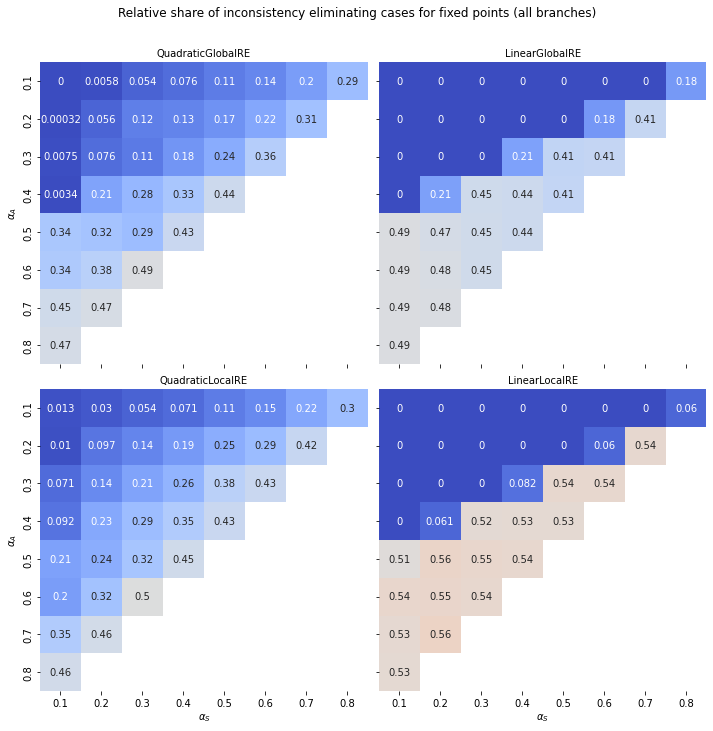

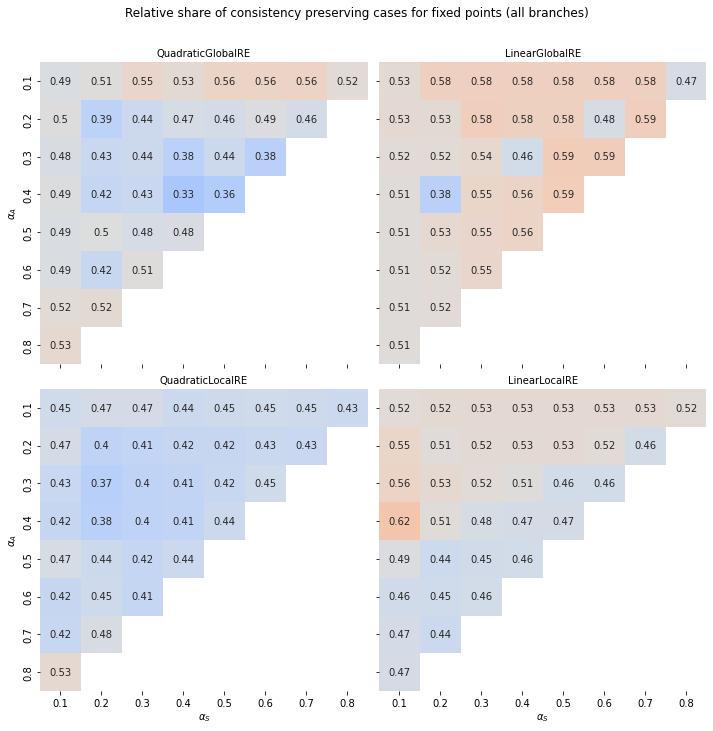

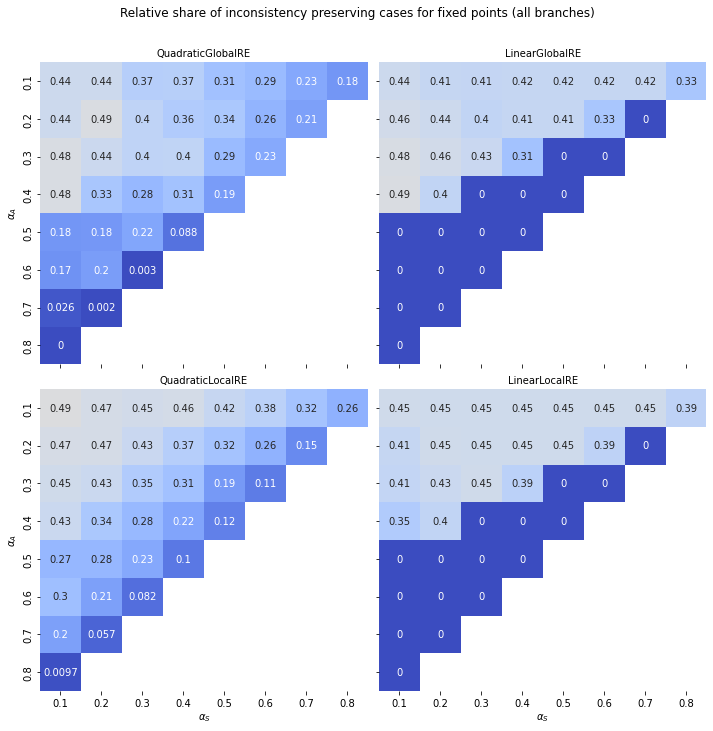

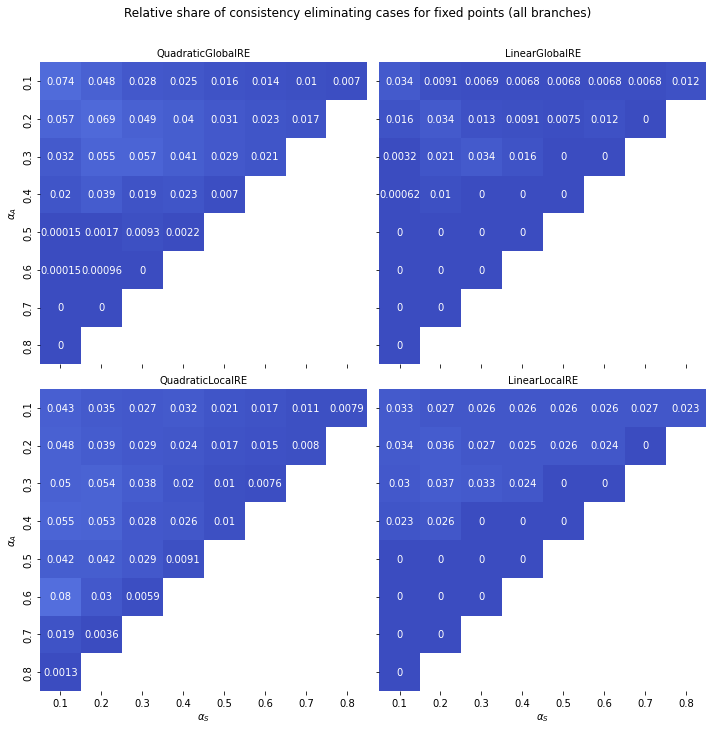

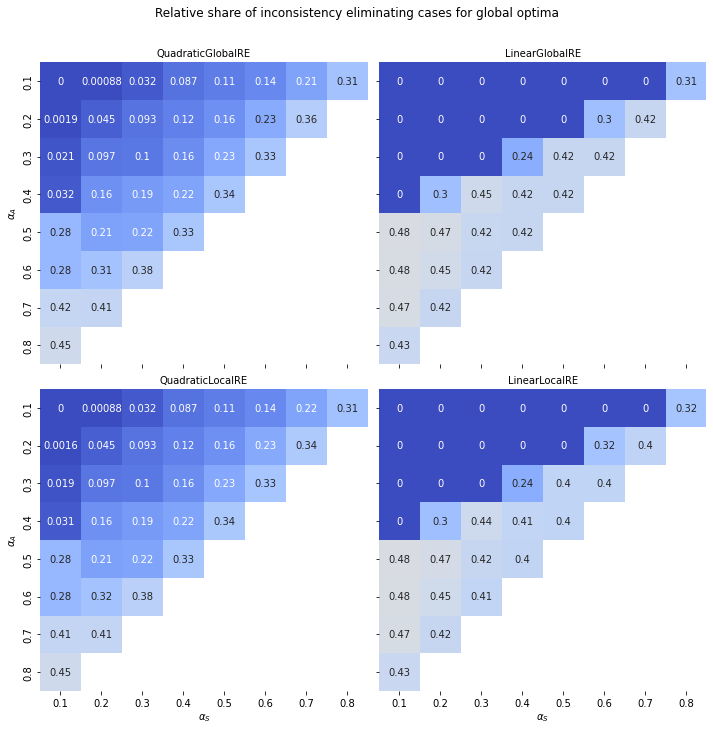

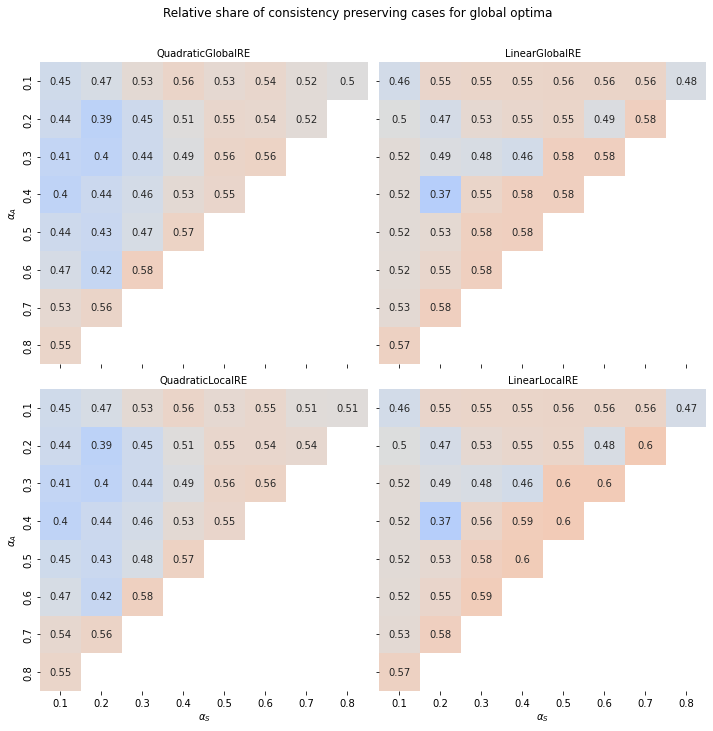

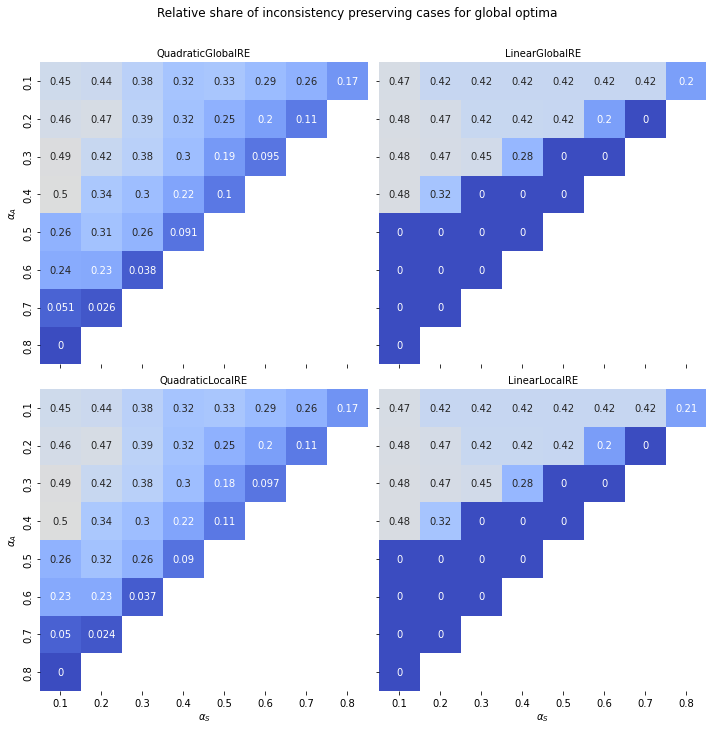

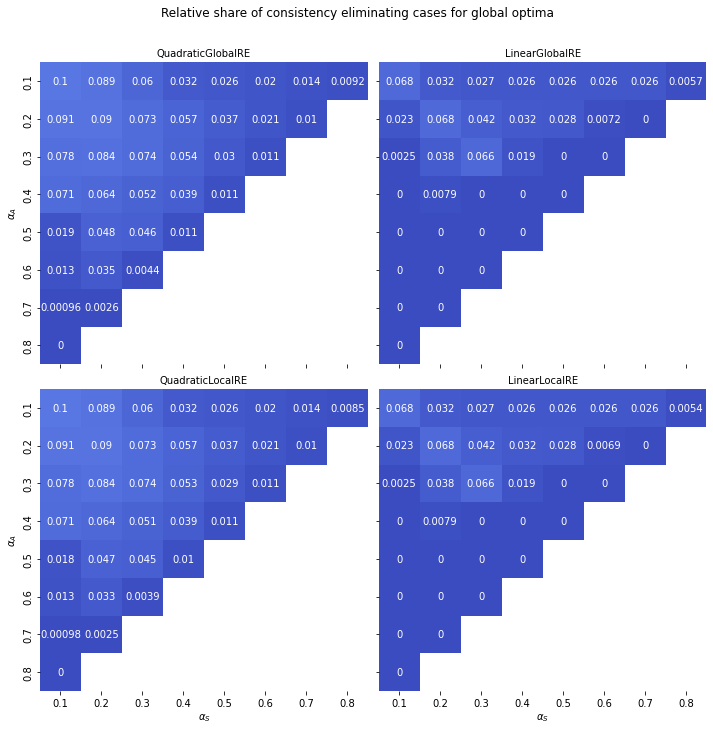

In [105]:
for df, endpoint_type in zip([fp_df, go_df], ['fp', 'go']):
    for case_name in ["inconsistency_eliminating", 
                      "consistency_preserving", 
                      "inconsistency_preserving", 
                      "consistency_eliminating"]:
        
        case_heatmaps_by_weights(df, endpoint_type, case_name, analyse_branches)
        
        branches = "branches" if analyse_branches else "setups"
        
        if export_results:
            plt.savefig(path.join(figures_output_dir, '{}_{}_cases_{}.png'.format(endpoint_type, case_name, branches)), bbox_inches='tight')
            plt.savefig(path.join(figures_output_dir, '{}_{}_cases_{}.pdf'.format(endpoint_type, case_name, branches)), bbox_inches='tight')

## Consistency III: Union
Is the union of output theory and output commitments dialectically consistent?

### Dialectical consistency of positions in global optima and fixed point

Here, we only count those in-/consistencies, which result from combining dialectically consistent commitments with their theories. In other words, we are interested in those inconsistencies in positions which cannot be explained by commitments being inconsistent on their own (which we already assessed above).

Relevant data fields:

+ The field `go_union_consistent`: A list of bools (List[bool]) indicating whether the unions of a commitment-theory-tuple of the global_optima are dialectically consistent. I.e. whether the global optima are RE states.The order of the list represents the order in global_optima.
+ The fied `fp_union_consistent`: A list of bools (List[bool]) indicating whether the unions of a commitment-theory-tuple of the fixed_points are dialectically consistent.The order of the list represents the order in fixed_points.

In [109]:


## The col `go_union_consistent` contains values indicating whether the union of coms and theories is 
## consistent. Here, we restrict the list to those values where the coms are consistent on their own.
#
## for gos
#re_data['go_union_consistent_restr'] = re_data.apply(lambda x: [x['go_union_consistent'][i] 
#                                                                 for i in range(x['n_global_optima']) 
#                                                                 if x['go_coms_consistent'][i]], axis=1)
#re_data['go_union_consistent_restr_count'] = re_data.apply(lambda x: sum(x['go_union_consistent_restr']) , axis=1)
#re_data['go_union_consistent_restr_size'] = re_data.apply(lambda x: len(x['go_union_consistent_restr']), axis=1)
## for fps
#re_data['fp_union_consistent_restr'] = re_data.apply(lambda x: [x['fp_union_consistent'][i] 
#                                                                 for i in range(x['n_fixed_points']) 
#                                                                 if x['fp_coms_consistent'][i]], axis=1)
#re_data['fp_union_consistent_restr_count'] = re_data.apply(lambda x: sum(x['fp_union_consistent_restr']) , axis=1)
#re_data['fp_union_consistent_restr_size'] = re_data.apply(lambda x: len(x['fp_union_consistent_restr']), axis=1)
#
#
## restrict data to unique simulation setups to prevent multiple counting of branches 
#re_data_unique_setups = re_data.drop_duplicates(["model_name",
#                         "ds",
#                         "n_sentence_pool",
#                         'weight_account', 
#                         'weight_systematicity',
#                         'weight_faithfulness', 
#                         'init_coms'
#                        ])

In [110]:
# global optima

# restrict to global optima with consistent commitments (otherwise union is trivially inconsistent)
restricted_go_data = exploded_go_data[exploded_go_data["go_coms_consistent"]]

restricted_go_data = restricted_go_data.groupby(grouping)["go_union_consistent"].agg(["sum", "size"]).reset_index()


restricted_go_data = restricted_go_data.rename(columns={'sum': "n_go_union_consistent",
                                                  'size': 'n_global_optima'})
# relative share
restricted_go_data["rel_go_union_consistent"] = restricted_go_data["n_go_union_consistent"]/restricted_go_data["n_global_optima"]

restricted_go_data

,model_name,n_go_union_consistent,n_global_optima,rel_go_union_consistent
0,LinearGlobalRE,522055,540556,0.965774
1,LinearLocalRE,535532,554525,0.965749
2,QuadraticGlobalRE,492856,529359,0.931043
3,QuadraticLocalRE,489618,525490,0.931736


In [111]:
# fixed points

# restrict to fixed points with consistent commitments (otherwise union is trivially inconsistent)
restricted_fp_data = exploded_fp_data[exploded_fp_data["fp_coms_consistent"]]

restricted_fp_data = restricted_fp_data.groupby(grouping)["fp_union_consistent"].agg(["sum", "size"]).reset_index()


restricted_fp_data = restricted_fp_data.rename(columns={'sum': "n_fp_union_consistent",
                                                  'size': 'n_fixed_points'})
# relative share
restricted_fp_data["rel_fp_union_consistent"] = restricted_fp_data["n_fp_union_consistent"]/restricted_fp_data["n_fixed_points"]

restricted_fp_data

,model_name,n_fp_union_consistent,n_fixed_points,rel_fp_union_consistent
0,LinearGlobalRE,218065,227097,0.960228
1,LinearLocalRE,1233142,1240692,0.993915
2,QuadraticGlobalRE,340059,374476,0.908093
3,QuadraticLocalRE,1333612,1463131,0.911478


In [112]:
for df, endpoint_type in zip([restricted_go_data, restricted_fp_data], ["go", "fp"]):
    
    # sort by model name
    df['model_name'] = pd.Categorical(df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
    df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   'n_go_union_consistent': 'Number of global optima with a consistent union',
                   'n_global_optima': 'Number of global optima with consistent commitments',
                   'rel_go_union_consistent': 'Relative share of global optima with a consistent union',
                   'n_fp_union_consistent': 'Number of fixed points with a consistent union',
                   'n_fixed_points': 'Number of fixed points with consistent commitments',
                   'rel_fp_union_consistent': 'Relative share of fixed points with a consistent union',
                  }

    display(df.rename(columns=cols_for_tables))
    
    # Exporting relevant cols
    if export_results:
        file_name = 'table_consistency_union_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Number of global optima with a consistent union,Number of global optima with consistent commitments,Relative share of global optima with a consistent union
2,QuadraticGlobalRE,492856,529359,0.931043
0,LinearGlobalRE,522055,540556,0.965774
3,QuadraticLocalRE,489618,525490,0.931736
1,LinearLocalRE,535532,554525,0.965749


,Model,Number of fixed points with a consistent union,Number of fixed points with consistent commitments,Relative share of fixed points with a consistent union
2,QuadraticGlobalRE,340059,374476,0.908093
0,LinearGlobalRE,218065,227097,0.960228
3,QuadraticLocalRE,1333612,1463131,0.911478
1,LinearLocalRE,1233142,1240692,0.993915


### Heatmaps

In [113]:
new_grouping = ["model_name", "weight_account", "weight_systematicity"]

In [114]:
# global optima

# restrict to global optima with consistent commitments (otherwise union is trivially inconsistent)
wrestricted_go_data = exploded_go_data[exploded_go_data["go_coms_consistent"]]

wrestricted_go_data = wrestricted_go_data.groupby(new_grouping)["go_union_consistent"].agg(["sum", "size"]).reset_index()


wrestricted_go_data = wrestricted_go_data.rename(columns={'sum': "n_go_union_consistent",
                                                  'size': 'n_global_optima'})
# relative share
wrestricted_go_data["rel_go_union_consistent"] = wrestricted_go_data["n_go_union_consistent"]/wrestricted_go_data["n_global_optima"]

# sort by model name
wrestricted_go_data['model_name'] = pd.Categorical(wrestricted_go_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
wrestricted_go_data.sort_values("model_name", inplace=True)

#wrestricted_go_data

In [115]:
# fixed points

# restrict to fixed points with consistent commitments (otherwise union is trivially inconsistent)
wrestricted_fp_data = exploded_fp_data[exploded_fp_data["fp_coms_consistent"]]

wrestricted_fp_data = wrestricted_fp_data.groupby(new_grouping)["fp_union_consistent"].agg(["sum", "size"]).reset_index()


wrestricted_fp_data = wrestricted_fp_data.rename(columns={'sum': "n_fp_union_consistent",
                                                  'size': 'n_fixed_points'})
# relative share
wrestricted_fp_data["rel_fp_union_consistent"] = wrestricted_fp_data["n_fp_union_consistent"]/wrestricted_fp_data["n_fixed_points"]


# sort by model name
wrestricted_fp_data['model_name'] = pd.Categorical(wrestricted_fp_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
wrestricted_fp_data.sort_values("model_name", inplace=True)


#wrestricted_fp_data

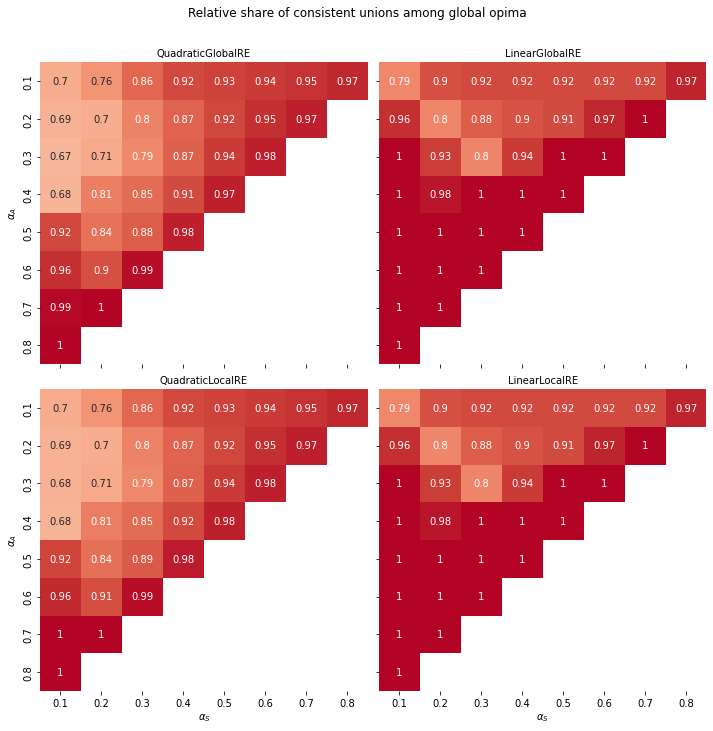

<Figure size 432x288 with 0 Axes>

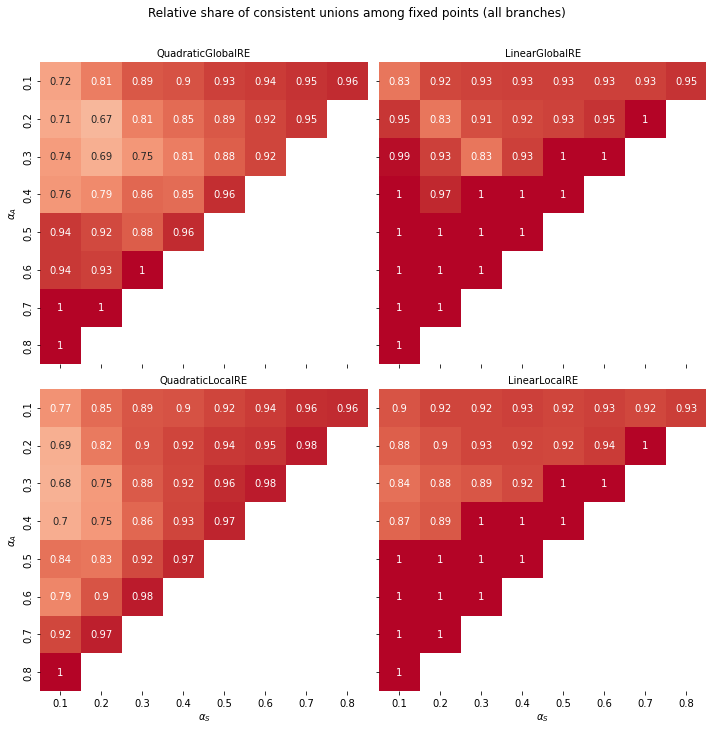

<Figure size 432x288 with 0 Axes>

In [116]:
for df, endpoint_type in zip([wrestricted_go_data, wrestricted_fp_data], ["go", "fp"]):

    endpoint = "global opima" if endpoint_type == "go" else "fixed points"
    
    if (analyse_branches) & (endpoint_type=="fp"):
        endpoint += " (all branches)"
    
    normalized_heat_maps_by_weights(re_data = df, 
                     values = "rel_{}_union_consistent".format(endpoint_type), 
                     title = 'Relative share of consistent unions among {}'.format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.1f}')
    plt.show()
    
    branches = "branches" if analyse_branches else "setups"
        
    if export_results:
        plt.savefig(path.join(figures_output_dir, 'weight_consistency_unions_{}_{}.png'.format(endpoint_type, branches)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'weight_consistency_unions_{}_{}.pdf'.format(endpoint_type, branches)), bbox_inches='tight')